In [1]:
from asteroid_interp import interp

In [10]:
constr_lval = \
'''
constructor A with arity 2.
let a = A(1,2,3).
let a@[1] = 0.
'''
interp(constr_lval, tree_dump=False, symtab_dump=True, exceptions=True)

ValueError: strcuture lval access not yet implemented

In [3]:
array_lval = \
'''
let a = [1,2,3].
let a@[2],a@[1],a@[0] = a.
print a
'''
interp(array_lval, tree_dump=False, symtab_dump=False, do_walk=True, exceptions=False)

('list', [('integer', '3'), ('integer', '2'), ('integer', '1')])


In [4]:
struct = \
'''
constructor A with arity 1.
constructor B with arity 2.

let x = A(1).
let y = B(1,2).

let A(z) = x.
let B(v,w) = y.

let xx = x@0.
let yy = y@[0,1].

'''
interp(struct, tree_dump=False, symtab_dump=True, exceptions=True)

Symbol Table Dump:
[{'A': [('constructor', ('arity', '1'))],
  'B': [('constructor', ('arity', '2'))],
  '__minus__': [('constructor', ('arity', 2))],
  '__plus__': [('constructor', ('arity', 2))],
  'v': [('integer', '1')],
  'w': [('integer', '2')],
  'x': [('juxta', ('id', 'A'), ('juxta', ('integer', '1'), ('nil',)))],
  'xx': [('integer', '1')],
  'y': [('juxta',
         ('id', 'B'),
         ('juxta', ('list', [('integer', '1'), ('integer', '2')]), ('nil',)))],
  'yy': [('list', [('integer', '1'), ('integer', '2')])],
  'z': [('integer', '1')]}]


In [ ]:
dict = \
'''
let d = [("a", 1)].

print d@{a}.
'''
interp(dict, tree_dump=True)

In [5]:
arr = \
'''
let v = 'a@[3].
print v.
'''
interp(arr)

('structure-ix', ('id', 'a'), ('index', ('list', [('integer', '3')]), ('nil',)))


In [9]:
func = \
'''
load "standard.ast".

function inc with n do return n+1 end function

let v = inc(inc(0)).
let q = 1 + 1 + 1.
print v, q.
'''
interp(func, tree_dump=False, symtab_dump=False)

('list', [('integer', 2), ('integer', 3)])


In [11]:
constr = \
'''
-- constructors and pattern matching

-- load "standard.ast".

constructor S with arity 1.
attach (lambda with n do return 1+n) to S.

let v = 'S(S(0)).
print v.

let v = S(S(0)).
print v.

let S (S (v))  = 'S(S(0)).
print v.

let S (S (0))  = 'S(S(0)).


let [[v]] = [[0]].
print v.

'''
interp(constr, tree_dump=False, symtab_dump=False, exceptions=False)

('juxta', ('id', 'S'), ('juxta', ('juxta', ('id', 'S'), ('juxta', ('integer', '0'), ('nil',))), ('nil',)))
('__plus__', ('integer', '1'), ('__plus__', ('integer', '1'), ('integer', '0')))
('integer', '0')
('integer', '0')


In [12]:
string_conc = \
'''
-- show off our overloaded '+' operator
load "standard.ast".

print 1 + 1.

let s1 = "hello".
let s2 = "world".
let s3 = s1 + " " + s2 +"!".
print s3.

let l1 = [1,2,3].
let l2 = [4,5,6].
let l3 = l1 + l2.
print l3
'''
interp(string_conc, tree_dump=False, symtab_dump=False, exceptions=False)

('integer', 2)
('string', 'hello world!')
('list', [('integer', '1'), ('integer', '2'), ('integer', '3'), ('integer', '4'), ('integer', '5'), ('integer', '6')])


In [13]:
array_rval = \
'''
-- reverse the list
let a = [1,2,3].
let a = a@[2,1,0].
print a.

-- access multidim array
let b = [[1,2,3],
         [4,5,6],
         [7,8,9]].
let e = b@[1]@[1].
print e.
'''
interp(array_rval, tree_dump=False, do_walk=True, symtab_dump=False, exceptions=False)

('list', [('integer', '3'), ('integer', '2'), ('integer', '1')])
('integer', '5')


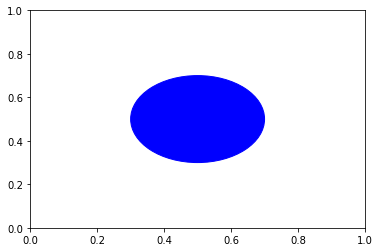

In [14]:
graphics = \
'''
-- Asteroid graphics
-- we can incorporate Python graphics into Asteroid via
-- escaped Python code

function circle with x, y, r do escape
"
#########################################################
vx = float(state.symbol_table.lookup_sym('x')[1])
vy = float(state.symbol_table.lookup_sym('y')[1])
vr = float(state.symbol_table.lookup_sym('r')[1])

import matplotlib.pyplot as plt

circle = plt.Circle((vx, vy), vr, color='blue')
fig, ax = plt.subplots()
ax.add_artist(circle)
plt.show()
#########################################################
"
end function

-- call the escaped function
circle(.5, .5, .2)
'''
interp(graphics, exceptions=False, tree_dump=False, symtab_dump=False, do_walk=True)

In [15]:
attach = \
'''
-- the 'add' function implements the behavior for 
-- the '+' operator for ints, reals, and strings.

function add with a, b do return escape 
"
###################################################################
# return register from 'escape' calls
global __retval__ 

# 'promote' is the type promotion table for primitive
# builtin types which implement the type hierarchy:
#    integer < real < string
type = promote(state.symbol_table.lookup_sym('a')[0], 
               state.symbol_table.lookup_sym('b')[0])

# select the correct add according to type
if type == 'integer':
    __retval__ = ('integer', 
            int(state.symbol_table.lookup_sym('a')[1]) + 
            int(state.symbol_table.lookup_sym('b')[1]))

elif type == 'real':
    __retval__ = ('real', 
            float(state.symbol_table.lookup_sym('a')[1]) + 
            float(state.symbol_table.lookup_sym('b')[1]))

elif type == 'string':
    __retval__ = ('string', 
            str(state.symbol_table.lookup_sym('a')[1])+
            str(state.symbol_table.lookup_sym('b')[1]))

else:
    raise ValueError('unsupported type in add')
###################################################################
"     
end function

-- attach the behavior to the '+' constructor
attach add to __plus__.

-- test the '+' operator with different data types
let x = 1.2 + 2 .
print x.
print "the output is: " + x.
-- print [1,2] + 3.
'''
interp(attach, tree_dump=False, symtab_dump=False, exceptions=False)

('real', 3.2)
('string', 'the output is: 3.2')


In [16]:
interp("let x = 1 + 2. print x.")

('__plus__', ('integer', '1'), ('integer', '2'))


In [17]:
interp("let x = 1.3 . print x.")

('real', '1.3')


In [18]:
interp("let 1,y = 1,2. print 1,y.")

('list', [('integer', '1'), ('integer', '2')])


In [19]:
interp("let x,2 = 1,2. print x,2.")

('list', [('integer', '1'), ('integer', '2')])


In [20]:
interp("let s = 1,2. let x,y = s. print x,y.")

('list', [('integer', '1'), ('integer', '2')])


In [21]:
interp("function ident with n do return n end function print ident(2).")

('integer', '2')


In [22]:
interp("let x = 1. function ident with n do return n end function print (ident( ident (x))) .", exceptions=True)

('integer', '1')


In [24]:
interp("let _, x = [1], 2.", symtab_dump=True)

Symbol Table Dump:
[{'__minus__': [('constructor', ('arity', 2))],
  '__plus__': [('constructor', ('arity', 2))],
  'x': [('integer', '2')]}]


In [25]:
lambda1 = \
'''
load "standard.ast"
print (lambda with n do return n+1) 1
'''
interp(lambda1, tree_dump=False, symtab_dump=False)

('integer', 2)
